In [1]:
from math import sqrt
import math
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

### Smartphone Camera Possition 1

In [2]:
def camera_position_1_convertion(x):

    #camera on the right hand side
    if x < 180:   #fp2 x
        Yb = 0.51    #fp2 rad
        Ya = 0.34    #fp3 rad
        Xa = 130     #fp3 x
        Xb = 180     #fp2 x 
    else:
        Yb = 0.93    #fp1 rad
        Xb = 294     #fp1 x
        Ya = 0.52    #fp2 rad
        Xa = 180     #fp2 x

    y= x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))
    return 3.14-y

### Smartphone Camera Possition 2

In [3]:
def camera_position_2_convertion(x):
    
    #camera on the left hand side
    
    if x > 347:      #fp2 x
        Yb = 0.36    #fp1 rad
        Xb = 404     #fp1 x     
        Ya = 0.55    #fp2 rad
        Xa = 347    #fp2 x

    else:
        Yb = 0.55    #fp2 rad
        Xb = 347    #fp2 x
        Ya = 1.01    #fp3 rad
        Xa = 210    #fp3 x

    y = x* ((Yb-Ya)/(Xb-Xa)) + (((Ya*Xb)-(Yb*Xa))/(Xb-Xa))

    return y

### Funtions

In [4]:
def radian_to_degree(x):
    return (x * 180)/3.14

def degree_to_radian(x):
    return (x * 3.14)/180

def bearing(sensor, target_pos):
    '''given the sensor position and the target position calculate the angle.
    m = (y2-y1)/(x2 - x1) than teta = arctan(m)'''
    
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])


def measurement(A_pos, B_pos, pos):
    '''given the positions of the two sensors, and the expected position of the target, 
    this function return the angle of the target respect to the two sensor.
    A_pos is the sensor at the left position, B_pos is the sensor at the right position.
    The angles are calculated in radian and the origin of the angle is the axes x.'''
    
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

def fx_VOR(x, dt, u):
    '''this function predict the next position of the target, given the actual position and the u'''

    current_x = x[0] 
    current_y = x[2]
    
    next_position = estimate_next_position([current_x, current_y], u)

    x[1] = abs(next_position[0] - current_x) / 100 / dt #transform cm to m
    
    x[3] = abs(next_position[1] - current_y) / 100 / dt 
    
    
    x[0] = next_position[0]
    x[2] = next_position[1]
    return x

sa_pos = [-323, 0]
sb_pos = [350, 0]

def hx_VOR(x):
    
    '''after predict the position, hx_VOR return the angle in respect of the sensors'''
    # measurement to A
    pos = (x[0], x[2])
    #print('pos: '+str(pos))
    #print(measurement(sa_pos, sb_pos, pos))
    #print('measurement: ' + str(measurement(sa_pos, sb_pos, pos)))
    return measurement(sa_pos, sb_pos, pos)

def intercept_between_two_line(s2, s1):
    
    '''given the position of the sensor and the angles calculated previously.
    This function create to virtual stright line and calculate and return the point of intercept'''
    
    #s1 is the position on the right
    #s2 is the position on the left
    
    #z1 is the position on the right
    #z2 is the position on the left
    
    
    #print('s1: {} s2: {}'.format(s1,s2))
    m1 = np.tan(degree_to_radian(radian_to_degree(s1)))
    c1 = sb_pos[1] - sb_pos[0] * m1 
    
    m2 = np.tan(s2)
    c2 = sa_pos[1] - sa_pos[0] * m2 
        
    x = (c2 - c1)/(m1 - m2)
    y = (x * m1) + c1
    
    #print('x: {} , y: {}'.format(x,y))
    return x, y  

def callculate_u(previous_x, previous_y , current_positions, dt):
    
    '''from the real measurement (z), we calculate the u vector, which represent the distance and the direction of our target'''
    
    delta_x = previous_x- current_positions[0]
    delta_y = previous_y- current_positions[1]
    
    if delta_x== 0:
        delta_x = 0.0001
    if delta_y== 0:
        delta_y = 0.0001
        
    m = delta_y/delta_x
    distance = np.sqrt(delta_x**2 + delta_y**2)
    
    direction = np.arctan(m)
    if (current_positions[1] >=previous_y) & (current_positions[0] >=previous_x): 
    
        temp = radian_to_degree(direction)
        return [distance, temp]
    
    elif (current_positions[1] >previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp]   
    
    elif (current_positions[1] <previous_y) & (current_positions[0] < previous_x):
        temp = 180 + radian_to_degree(direction)
        return [distance, temp] 
    elif (current_positions[1] <previous_y) & (current_positions[0] > previous_x):
        temp = 360 + radian_to_degree(direction)
        return [distance, temp]
    
def estimate_next_position(current_position, u):

    '''given the actual position of the target, and given the vector u with distance and angle, 
    this function return the next position'''
    
    x = current_position[0]
    y = current_position[1]
    y_delta = np.sin(degree_to_radian(u[1])) * u[0]
    x_delta = np.cos(degree_to_radian(u[1])) * u[0]
    
    return [x+x_delta, y + y_delta]    

def moving_target_filter(pos, std_noise, Q, dt, kappa=0.0):
    '''step to create the initialize the unscented kalman filters'''
    
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    #print(f)
    
    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 200    
    return f

def plot_straight_line_target(f, std_noise, previous_position_x, previous_position_y, add_std_noise = False):
    
    xs, txs = [], []    
    
    txs.append((previous_position_x, previous_position_y))    

    for i in range(len(z_1)):
        z = [z_2[i], z_1[i]] 
        
        temp_position_x, temp_position_y = intercept_between_two_line(z[0], z[1])
        
        txs.append((temp_position_x, temp_position_y))
        
        if (add_std_noise):
            
            print('\nbefore the noise adding : '+str(z[0]) + ' ' +str(z[1]))
            z[0] += randn() * std_noise
            z[1] += randn() * std_noise
            print('after the noise adding : '+str(z[0]) + ' ' +str(z[1]))
        
            temp_position_x, temp_position_y = intercept_between_two_line(z[0], z[1])
        
        
        current_target_position = [temp_position_x, temp_position_y]
        
        u = callculate_u(previous_position_x, previous_position_y, current_target_position, 0.06)
        

        
        previous_position_x = temp_position_x
        previous_position_y = temp_position_y

        f.predict(u=u)

        f.update(z)
        xs.append(f.x)
                    
    xs = np.asarray(xs)
    txs = np.asarray(txs)
    #print(xs)

    return xs, txs

### import data and create files

In [5]:
video_list = range(1,11)

In [7]:
both_phone_glasses_distance = []
both_phone_mixed1_distance = []
both_phone_mixed2_distance = []


for video_number in video_list:
    data_smartphone_x1 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X1.csv'.format(video_number))
    data_smartphone_x2 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} S10 position X2.csv'.format(video_number))

    data_smartphone_x1 = data_smartphone_x1.drop(['Unnamed: 0'], axis=1)
    data_smartphone_x2 = data_smartphone_x2.drop(['Unnamed: 0'], axis=1)


    angles_smartphone_1 = [camera_position_1_convertion(x) for x in data_smartphone_x1['x-coordinate']]
    angles_smartphone_2 = [camera_position_2_convertion(x) for x in data_smartphone_x2['x-coordinate']]
    data_smartphone_x1['angle'] = angles_smartphone_1
    data_smartphone_x2['angle'] = angles_smartphone_2
    
    data_smartglasses_x1 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} SG position X1.csv'.format(video_number))
    data_smartglasses_x2 = pd.read_csv('../Data/Data from camera in X1 and X2/Video{} SG position X2.csv'.format(video_number))
    
    
    ################################################## smarphone both side ##############################################

    z_1 = []
    for i in range(16,len(data_smartphone_x1),15):
        z_1.append(data_smartphone_x1['angle'][i-15:i].mean())
    z_2 = []
    for i in range(16,len(data_smartphone_x2),15):
        z_2.append(data_smartphone_x2['angle'][i-15:i].mean())


    distance = abs(len(z_1) - len(z_2))
    if distance>0:
        for i in range(distance):
            if len(z_1) > len(z_2):
                del z_1[-1]
            else:
                del z_2[-1]

    np.random.seed(123)
    target_temp = intercept_between_two_line(z_2[0], z_1[0])
    target_pos = [0,0]
    target_pos[0] = round(target_temp[0],5)
    target_pos[1] = round(target_temp[1],5)
    std_noise = math.radians(0.5)
    dt = 0.5
    Q=1.0
    f = moving_target_filter(target_pos, std_noise, Q , dt)
    xs_both_smartphone, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1], add_std_noise=False)
    
    ################################################## smartglasses both positions ####################################

    z_1 = []
    for i in range(16,len(data_smartglasses_x1),15):
        z_1.append(data_smartglasses_x1['angle'][i-15:i].mean())
    z_2 = []
    for i in range(16,len(data_smartglasses_x2),15):
        z_2.append(data_smartglasses_x2['angle'][i-15:i].mean())


    distance = abs(len(z_1) - len(z_2))
    if distance>0:
        for i in range(distance):
            if len(z_1) > len(z_2):
                del z_1[-1]
            else:
                del z_2[-1]

    np.random.seed(123)
    target_temp = intercept_between_two_line(z_2[0], z_1[0])
    target_pos = [0,0]
    target_pos[0] = round(target_temp[0],5)
    target_pos[1] = round(target_temp[1],5)
    std_noise = math.radians(0.5)
    dt = 0.5
    Q=1.0
    f = moving_target_filter(target_pos, std_noise, Q , dt)
    xs_both_smartglasses, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1], add_std_noise=False)    

    ############################################ smartglasses right, smarphone left ########################################

    z_1 = []
    for i in range(16,len(data_smartglasses_x1),15):
        z_1.append(data_smartglasses_x1['angle'][i-15:i].mean())
    z_2 = []
    for i in range(16,len(data_smartphone_x2),15):
        z_2.append(data_smartphone_x2['angle'][i-15:i].mean())


    distance = abs(len(z_1) - len(z_2))
    if distance>0:
        for i in range(distance):
            if len(z_1) > len(z_2):
                del z_1[-1]
            else:
                del z_2[-1]

    np.random.seed(123)
    target_temp = intercept_between_two_line(z_2[0], z_1[0])
    target_pos = [0,0]
    target_pos[0] = round(target_temp[0],5)
    target_pos[1] = round(target_temp[1],5)
    std_noise = math.radians(0.5)
    dt = 0.5
    Q=1.0
    f = moving_target_filter(target_pos, std_noise, Q , dt)
    xs_phoneleft_glassesright, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1], add_std_noise=False)
    
    ########################################### smartglasses left, smarphone right #########################################

    z_1 = []
    for i in range(16,len(data_smartphone_x1),15):
        z_1.append(data_smartphone_x1['angle'][i-15:i].mean())
    z_2 = []
    for i in range(16,len(data_smartglasses_x2),15):
        z_2.append(data_smartglasses_x2['angle'][i-15:i].mean())


    distance = abs(len(z_1) - len(z_2))
    if distance>0:
        for i in range(distance):
            if len(z_1) > len(z_2):
                del z_1[-1]
            else:
                del z_2[-1]

    np.random.seed(123)
    target_temp = intercept_between_two_line(z_2[0], z_1[0])
    target_pos = [0,0]
    target_pos[0] = round(target_temp[0],5)
    target_pos[1] = round(target_temp[1],5)
    std_noise = math.radians(0.5)
    dt = 0.5
    Q=1.0
    f = moving_target_filter(target_pos, std_noise, Q , dt)

    xs_phoneright_glassesleft, txs = plot_straight_line_target(f, std_noise, target_pos[0], target_pos[1], add_std_noise=False) 
    
    
    distance_between_xs_phone_glasses = []
    for i in range(len(xs_both_smartglasses)):
        distance_between_xs_phone_glasses.append(abs(xs_both_smartphone[:,0][i] - xs_both_smartglasses[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_both_smartglasses[:,2][i]))
    both_phone_glasses_distance.append(round(np.array(distance_between_xs_phone_glasses).mean(),2))
    
    distance_between_xs_bothphones_mixedglassesphones = []
    for i in range(len(xs_both_smartglasses)):
        distance_between_xs_bothphones_mixedglassesphones.append(abs(xs_both_smartphone[:,0][i] - xs_phoneleft_glassesright[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_phoneleft_glassesright[:,2][i]))  
    both_phone_mixed1_distance.append(round(np.array(distance_between_xs_bothphones_mixedglassesphones).mean(),2))
    
    distance_between_xs_bothphones_mixedglassesphones_2 = []
    for i in range(len(xs_both_smartglasses)):
        distance_between_xs_bothphones_mixedglassesphones_2.append(abs(xs_both_smartphone[:,0][i] - xs_phoneright_glassesleft[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_phoneright_glassesleft[:,2][i]))
    both_phone_mixed2_distance.append(round(np.array(distance_between_xs_bothphones_mixedglassesphones_2).mean(),2))
    
table_overall_distance = pd.DataFrame()
table_overall_distance['video number'] = video_list
table_overall_distance['distance SS - GG (cm)'] = both_phone_glasses_distance
table_overall_distance['distance SS - GS (cm)'] = both_phone_mixed1_distance
table_overall_distance['distance SS - SG (cm)'] = both_phone_mixed2_distance
table_overall_distance

,video number,distance SS - GG (cm),distance SS - GS (cm),distance SS - SG (cm)
0,1,5.62,4.25,2.84
1,2,6.05,4.03,3.73
2,3,5.99,4.74,3.33
3,4,6.23,3.61,4.26
4,5,5.63,3.93,3.61
5,6,7.31,6.38,2.49
6,7,4.99,3.22,3.24
7,8,5.90,3.71,3.82
8,9,5.77,4.13,3.18
9,10,5.47,3.63,3.28


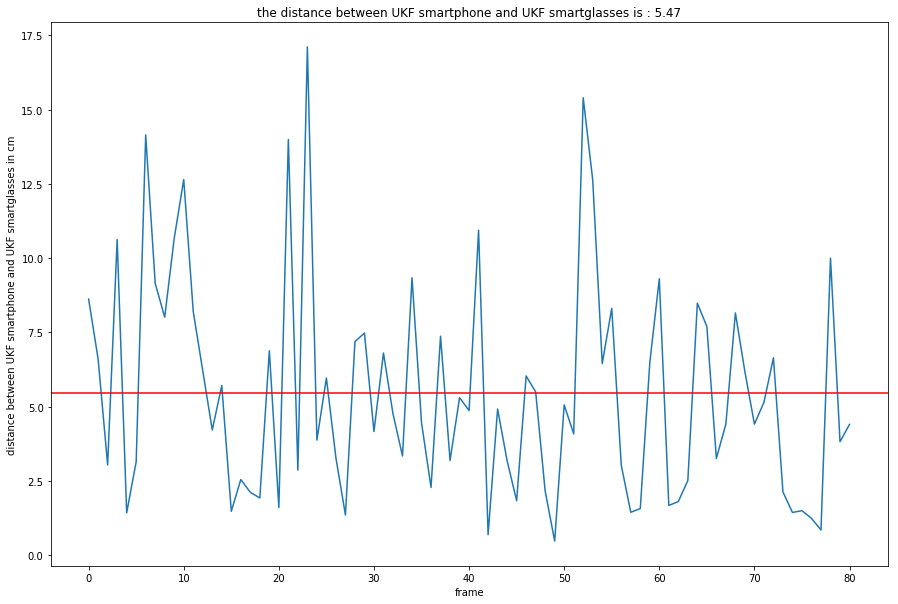

In [10]:
distance_between_xs_phone_glasses = []
for i in range(len(xs_both_smartglasses)):
    distance_between_xs_phone_glasses.append(abs(xs_both_smartphone[:,0][i] - xs_both_smartglasses[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_both_smartglasses[:,2][i]))

  
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(xs_both_smartglasses)), distance_between_xs_phone_glasses)
f = plt.xlabel('frame')
f = plt.ylabel('distance between UKF smartphone and UKF smartglasses in cm')
f = plt.title('the distance between UKF smartphone and UKF smartglasses is : '+str(round(np.array(distance_between_xs_phone_glasses).mean(),2)))
f = plt.axhline(y = np.array(distance_between_xs_phone_glasses).mean(), xmin=0 , xmax=1 , color='red')

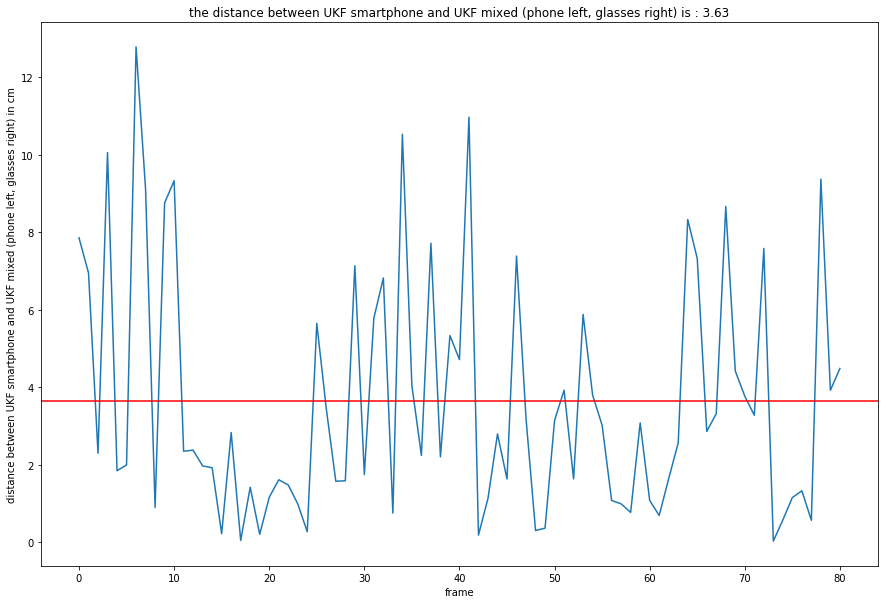

In [11]:
distance_between_xs_bothphones_mixedglassesphones = []
for i in range(len(xs_both_smartglasses)):
    distance_between_xs_bothphones_mixedglassesphones.append(abs(xs_both_smartphone[:,0][i] - xs_phoneleft_glassesright[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_phoneleft_glassesright[:,2][i]))

  
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(xs_both_smartglasses)), distance_between_xs_bothphones_mixedglassesphones)
f = plt.xlabel('frame')
f = plt.ylabel('distance between UKF smartphone and UKF mixed (phone left, glasses right) in cm')
f = plt.title('the distance between UKF smartphone and UKF mixed (phone left, glasses right) is : ' +str(round(np.array(distance_between_xs_bothphones_mixedglassesphones).mean(),2)))
f = plt.axhline(y = np.array(distance_between_xs_bothphones_mixedglassesphones).mean(), xmin=0 , xmax=1 , color='red')

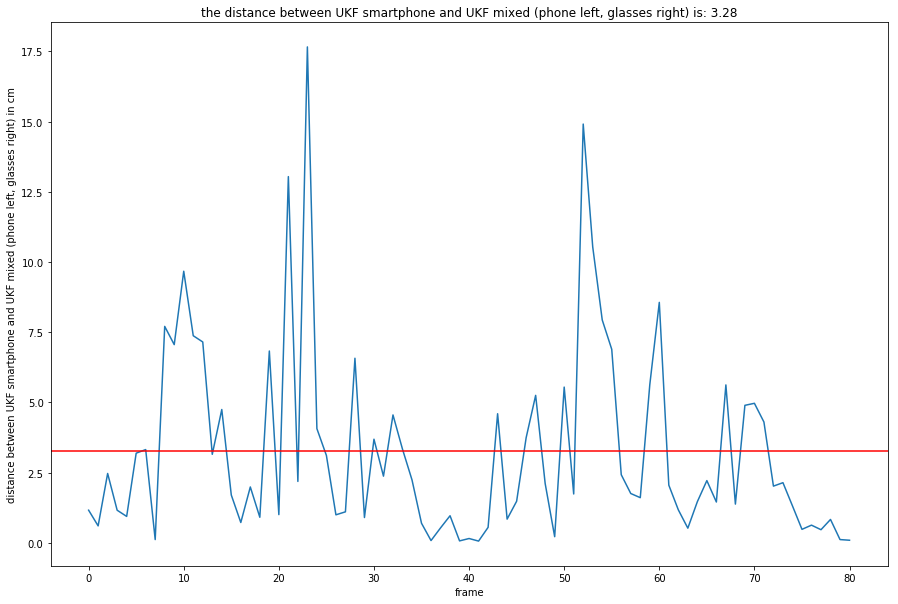

In [12]:
distance_between_xs_bothphones_mixedglassesphones_2 = []
for i in range(len(xs_both_smartglasses)):
    distance_between_xs_bothphones_mixedglassesphones_2.append(abs(xs_both_smartphone[:,0][i] - xs_phoneright_glassesleft[:,0][i]) + abs(xs_both_smartphone[:,2][i] - xs_phoneright_glassesleft[:,2][i]))

  
f = plt.figure(figsize=[15,10])
f = plt.plot(range(len(xs_both_smartglasses)), distance_between_xs_bothphones_mixedglassesphones_2)
f = plt.xlabel('frame')
f = plt.ylabel('distance between UKF smartphone and UKF mixed (phone left, glasses right) in cm')
f = plt.title('the distance between UKF smartphone and UKF mixed (phone left, glasses right) is: ' +str(round(np.array(distance_between_xs_bothphones_mixedglassesphones_2).mean(),2)))
f = plt.axhline(y = np.array(distance_between_xs_bothphones_mixedglassesphones_2).mean(), xmin=0 , xmax=1 , color='red')

# Validation

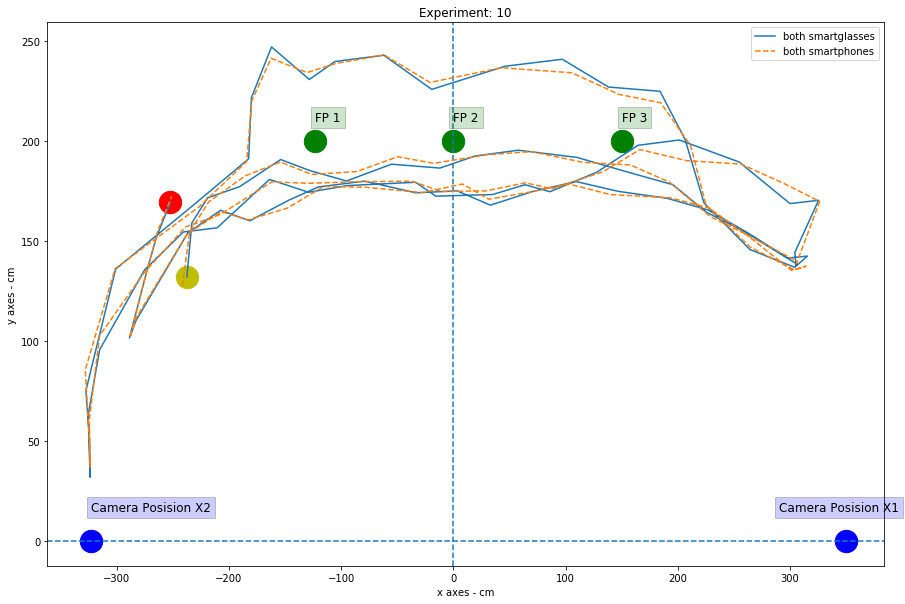

In [9]:
fix_position_1 = [150, 200]
fix_position_2 = [0, 200]
fix_position_3 = [-123, 200]


f = plt.figure(figsize=[15,10])
f = plt.scatter(sa_pos[0], sa_pos[1], c ='b', s=500)
f = plt.scatter(sb_pos[0], sb_pos[1], c = 'b', s=500)
f = plt.axhline(y = 0, xmin=0, xmax=1, linestyle='--')
f = plt.axvline(x = 0, ymin=0, ymax=1, linestyle='--')

f = plt.scatter(fix_position_1[0], fix_position_1[1], c ='g', s=500)
f = plt.scatter(fix_position_2[0], fix_position_2[1], c ='g', s=500)
f = plt.scatter(fix_position_3[0], fix_position_3[1], c ='g', s=500)


f = plt.text(-323, 15, 'Camera Posision X2', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))
f = plt.text(290, 15, 'Camera Posision X1', fontsize=12, bbox=dict(facecolor='blue', alpha=0.2))

f = plt.text(-123, 210, 'FP 1', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(0, 210, 'FP 2', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))
f = plt.text(150, 210, 'FP 3', fontsize=12, bbox=dict(facecolor='green', alpha=0.2))

f = plt.ylabel('y axes - cm')
f = plt.xlabel('x axes - cm')

f = plt.scatter(xs_both_smartglasses[:, 0][0], xs_both_smartglasses[:, 2][0], c ='y', s=500)
f = plt.plot(xs_both_smartglasses[:, 0], xs_both_smartglasses[:, 2], label = "both smartglasses")
f = plt.plot(xs_both_smartphone[:, 0], xs_both_smartphone[:, 2], '--', label = "both smartphones")
f = plt.scatter(xs_both_smartglasses[:, 0][-1], xs_both_smartglasses[:, 2][-1], c ='r', s=500)
f = plt.legend()

f = plt.title('Experiment: ' + str(video_number))